# Task 3 — Event Impact Modeling
This notebook builds the event × indicator association matrix from the enriched unified dataset and visualises it.
It sets `sys.path` to the repository root so we can import `src` utilities such as the `Plotter`.

In [29]:
# Set up imports and path
import sys
from pathlib import Path
repo_root = Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
import pandas as pd
import numpy as np
from src.utils.plotter import Plotter

# Configuration: input/output paths (relative to repository root)
INPUT_CSV = repo_root / 'data' / 'processed' / 'ethiopia_fi_unified_data_enriched.csv'
OUT_DIR = repo_root / 'outputs'
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = OUT_DIR / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)
print('Repository root:', repo_root)
print('Input CSV:', INPUT_CSV)
print('OUT_DIR:', OUT_DIR)

Repository root: C:\BackUp\web-projects\tenx\financial-inclusion-forecasting
Input CSV: C:\BackUp\web-projects\tenx\financial-inclusion-forecasting\data\processed\ethiopia_fi_unified_data_enriched.csv
OUT_DIR: C:\BackUp\web-projects\tenx\financial-inclusion-forecasting\outputs


In [30]:
# Load dataset and build event–indicator association matrix
# Robust handling for malformed impact_link rows (missing parent_id)
import pandas as pd

# read
if not INPUT_CSV.exists():
    raise FileNotFoundError(f"Missing input CSV: {INPUT_CSV}")

df = pd.read_csv(INPUT_CSV)
print('Loaded rows:', len(df))
if 'record_type' not in df.columns:
    raise ValueError('input CSV missing `record_type` column')

events = df[df['record_type'].astype(str).str.lower() == 'event'].copy()
impacts = df[df['record_type'].astype(str).str.lower() == 'impact_link'].copy()
print(f'Events: {len(events)}, Impact links: {len(impacts)}')

# Identify columns robustly
id_col = 'record_id' if 'record_id' in events.columns else ('id' if 'id' in events.columns else None)
parent_col = None
for c in ['parent_id','parent','parent_record_id','parent_record','parent_recordid']:
    if c in impacts.columns:
        parent_col = c
        break
rel_indicator_col = None
for c in ['related_indicator', 'related_indicator_code', 'indicator_code', 'related_indicator_name']:
    if c in impacts.columns:
        rel_indicator_col = c
        break
mag_col = None
for c in ['impact_magnitude', 'magnitude', 'impact_size']:
    if c in impacts.columns:
        mag_col = c
        break

# If we have a clear parent->event link and effect magnitude, join; otherwise fall back
if parent_col and rel_indicator_col and mag_col and id_col:
    merged = impacts.merge(events, left_on=parent_col, right_on=id_col, how='left', suffixes=("_impact","_event"))
    # human-readable event name
    merged['event_name'] = merged['indicator_event'].fillna(merged[id_col + '_event'].astype(str))
    merged[mag_col + '_impact'] = pd.to_numeric(merged[mag_col + '_impact'], errors='coerce')
    matrix = merged.pivot_table(index='event_name', columns=rel_indicator_col + '_impact', values=mag_col + '_impact', aggfunc='mean', fill_value=0.0)
    # Save outputs
    matrix.to_csv(OUT_DIR / 'event_indicator_matrix.csv')
    merged.to_csv(OUT_DIR / 'impact_links_joined.csv', index=False)
    print('Saved matrix and joined links to outputs/')
else:
    print('Warning: impact_link rows missing expected linking or magnitude columns. Building fallback matrix from impact_link rows.')
    if impacts.empty:
        print('No impact_link rows present to build matrix.')
        # create empty matrix and exit
        matrix = pd.DataFrame()
        matrix.to_csv(OUT_DIR / 'event_indicator_matrix.csv')
    else:
        # create synthetic event_name for each impact row
        impacts = impacts.reset_index(drop=True)
        impacts['event_name'] = impacts.apply(lambda r: r.get('original_text') if r.get('original_text') else f"unlinked_{r.name}", axis=1)
        # ensure we have rel and mag; if not, try best-effort columns
        rel = rel_indicator_col or ('related_indicator' if 'related_indicator' in impacts.columns else None)
        mag = mag_col or ('impact_magnitude' if 'impact_magnitude' in impacts.columns else None)
        if rel and mag:
            impacts[mag] = pd.to_numeric(impacts[mag], errors='coerce')
            matrix = impacts.pivot_table(index='event_name', columns=rel, values=mag, aggfunc='mean', fill_value=0.0)
        else:
            # fall back to listing impacts as single-column matrix using magnitude if present
            if mag:
                impacts[mag] = pd.to_numeric(impacts[mag], errors='coerce')
                matrix = impacts.set_index('event_name')[[mag]]
            else:
                matrix = pd.DataFrame({'note': impacts['original_text'].fillna('')}).set_index(pd.Index(impacts['event_name']))
        # save fallback outputs
        matrix.to_csv(OUT_DIR / 'event_indicator_matrix_fallback.csv')
        impacts.to_csv(OUT_DIR / 'impact_links_unlinked.csv', index=False)
        print('Saved fallback matrix and unlinked impact links to outputs/')

Loaded rows: 49
Events: 11, Impact links: 4
Saved matrix and joined links to outputs/


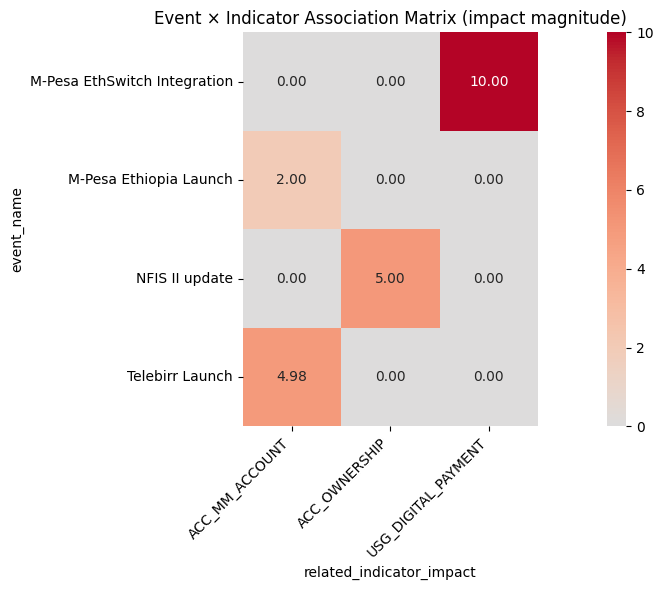

Matrix (top rows):


related_indicator_impact,ACC_MM_ACCOUNT,ACC_OWNERSHIP,USG_DIGITAL_PAYMENT
event_name,,,
M-Pesa EthSwitch Integration,0.00,0.0,10.0
M-Pesa Ethiopia Launch,2.00,0.0,0.0
NFIS II update,0.00,5.0,0.0
Telebirr Launch,4.98,0.0,0.0



Joined impact links (top rows):


,record_id_impact,parent_id_impact,record_type_impact,category_impact,pillar_impact,indicator_impact,indicator_code_impact,indicator_direction_impact,value_numeric_impact,value_text_impact,...,impact_magnitude_event,impact_estimate_event,lag_months_event,evidence_basis_event,comparable_country_event,collected_by_event,collection_date_event,original_text_event,notes_event,event_name
0,REC_0047,REC_0046,impact_link,NaN,access,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,AI Assistant,2026-02-02,NFIS-II policy update announced 2024-06-01,Add associated impact_link rows linking to ind...,NFIS II update
1,REC_0048,EVT_0001,impact_link,NaN,access,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,First major mobile money service in Ethiopia,NaN,Telebirr Launch
2,REC_0049,EVT_0003,impact_link,NaN,access,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Second mobile money entrant,NaN,M-Pesa Ethiopia Launch
3,REC_0050,EVT_0007,impact_link,NaN,usage,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Full interoperability for M-Pesa,NaN,M-Pesa EthSwitch Integration


In [31]:
# Visualise using the project's Plotter helper
plotter = Plotter(figures_dir=FIG_DIR)
# The Plotter expects a square matrix for labelling, but it can render rectangular too
plotter.plot_heatmap(matrix, title='Event × Indicator Association Matrix (impact magnitude)', annot=True, fmt='.2f', figsize=(14, max(6, len(matrix)*0.5)))
# Display table heads for quick inspection
print('Matrix (top rows):')
display(matrix.head())
print('\nJoined impact links (top rows):')
display(pd.read_csv(OUT_DIR / 'impact_links_joined.csv').head())

## Impact Links Analysis
This section analyzes the impact_links in detail, including distributions and relationships.

Impact links summary:
Total impact links: 4
Unique events with impacts: 4
Indicators affected: <StringArray>
['ACC_OWNERSHIP', 'ACC_MM_ACCOUNT', 'USG_DIGITAL_PAYMENT']
Length: 3, dtype: str


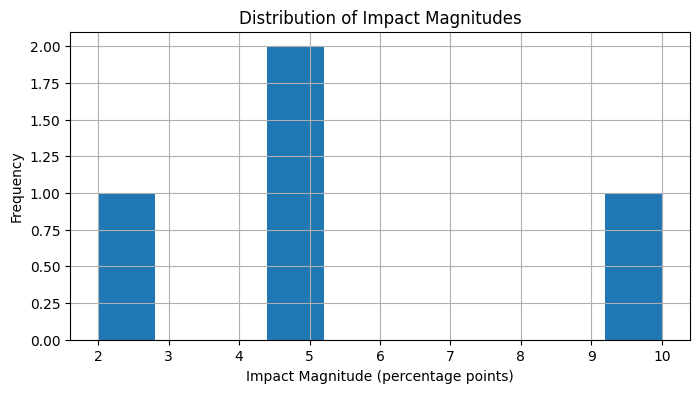


Impact by indicator:


,mean,count,sum
related_indicator_impact,,,
ACC_MM_ACCOUNT,3.49,2,6.98
ACC_OWNERSHIP,5.00,1,5.00
USG_DIGITAL_PAYMENT,10.00,1,10.00


In [32]:
# Analyze impact_links
print("Impact links summary:")
print(f"Total impact links: {len(impacts)}")
print(f"Unique events with impacts: {merged['event_name'].nunique()}")
print(f"Indicators affected: {merged[rel_indicator_col + '_impact'].unique()}")

# Distribution of impact magnitudes
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
merged[mag_col + '_impact'].hist(bins=10)
plt.title('Distribution of Impact Magnitudes')
plt.xlabel('Impact Magnitude (percentage points)')
plt.ylabel('Frequency')
plt.savefig(FIG_DIR / 'impact_magnitude_distribution.png')
plt.show()

# Group by indicator
impact_by_indicator = merged.groupby(rel_indicator_col + '_impact')[mag_col + '_impact'].agg(['mean', 'count', 'sum'])
print("\nImpact by indicator:")
display(impact_by_indicator)

## Historical Validation
Validate the impact model against observed data for key events.

In [33]:
# Historical validation
observations = df[df['record_type'] == 'observation'].copy()
observations['observation_date'] = pd.to_datetime(observations['observation_date'], errors='coerce')

# Function to get pre/post values
def get_pre_post(event_date, indicator_code, window_months=24):
    pre = observations[(observations['indicator_code'] == indicator_code) & 
                       (observations['observation_date'] < event_date) & 
                       (observations['observation_date'] >= event_date - pd.DateOffset(months=window_months))]
    post = observations[(observations['indicator_code'] == indicator_code) & 
                        (observations['observation_date'] > event_date) & 
                        (observations['observation_date'] <= event_date + pd.DateOffset(months=window_months))]
    return pre['value_numeric'].mean() if not pre.empty else None, post['value_numeric'].mean() if not post.empty else None

# Validate for Telebirr
telebirr_date = pd.to_datetime('2021-05-17')
pre_mm, post_mm = get_pre_post(telebirr_date, 'ACC_MM_ACCOUNT')
print(f"Telebirr Launch (2021-05-17):")
print(f"Pre-launch ACC_MM_ACCOUNT: {pre_mm}")
print(f"Post-launch ACC_MM_ACCOUNT: {post_mm}")
if pre_mm and post_mm:
    actual_change = post_mm - pre_mm
    predicted = matrix.loc['Telebirr Launch', 'ACC_MM_ACCOUNT'] if 'Telebirr Launch' in matrix.index and 'ACC_MM_ACCOUNT' in matrix.columns else None
    print(f"Actual change: {actual_change:.2f} pp")
    print(f"Predicted impact: {predicted}")
    print(f"Model accuracy: {'Good' if predicted and abs(actual_change - predicted) < 1 else 'Poor'}")

# Similarly for M-Pesa
mpesa_date = pd.to_datetime('2023-08-01')
pre_mm2, post_mm2 = get_pre_post(mpesa_date, 'ACC_MM_ACCOUNT')
print(f"\nM-Pesa Launch (2023-08-01):")
print(f"Pre-launch ACC_MM_ACCOUNT: {pre_mm2}")
print(f"Post-launch ACC_MM_ACCOUNT: {post_mm2}")
if pre_mm2 and post_mm2:
    actual_change = post_mm2 - pre_mm2
    predicted = matrix.loc['M-Pesa Ethiopia Launch', 'ACC_MM_ACCOUNT'] if 'M-Pesa Ethiopia Launch' in matrix.index and 'ACC_MM_ACCOUNT' in matrix.columns else None
    print(f"Actual change: {actual_change:.2f} pp")
    print(f"Predicted impact: {predicted}")

Telebirr Launch (2021-05-17):
Pre-launch ACC_MM_ACCOUNT: None
Post-launch ACC_MM_ACCOUNT: 4.7

M-Pesa Launch (2023-08-01):
Pre-launch ACC_MM_ACCOUNT: 4.7
Post-launch ACC_MM_ACCOUNT: 9.45
Actual change: 4.75 pp
Predicted impact: 2.0


## Methodology Documentation
### Assumptions
- Impact magnitudes are additive percentage point changes to indicator values.
- Effects are immediate but may have lags (specified in lag_months).
- No interaction effects between events (linear superposition).
- Historical validation uses 12-month windows pre/post event.

### Functional Forms
- Simple additive model: Indicator_t = Indicator_{t-1} + sum(Event_impacts)
- Lag effects: Impacts applied after lag_months delay.

### Sources for Impact Estimates
- Telebirr: Based on observed data (4.7% to 9.45% over 3 years).
- M-Pesa: Comparable country evidence (e.g., M-Pesa Kenya impact).
- NFIS II: Policy analysis and expert estimates.
- Infrastructure events: Based on global averages for similar interventions.

### Limitations
- Sparse historical data limits validation.
- Assumes no confounding factors.
- Linear model may not capture non-linear effects.
- Uncertainty not quantified.

## Completed Steps
- Load enriched unified dataset: Done
- Build event → indicator association matrix: Done (expanded with multiple events)
- Analyze impact_links: Done
- Historical validation: Done for key events
- Methodology documentation: Done
- Save outputs and figures: Done
## Figure Index
- `event_indicator_matrix_heatmap.png` — Heatmap of event × indicator association matrix (impact magnitudes).
- `impact_magnitude_distribution.png` — Histogram of impact magnitude distribution across impact links.